# MobileNet test notebook

## Imports

In [51]:
# tensorflow and keras
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import keras
from keras import layers
from keras.models import Sequential
from keras import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, Conv1D, MaxPooling1D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, GlobalAveragePooling1D, LSTM
from keras.utils import to_categorical
from keras import applications

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.utils import compute_class_weight
from sklearn import metrics

# other
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = ''
import random
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns

## Variables

In [66]:
datadir = 'data/Garbage-classification/Garbage-classification/'
n_categories = 6
img_size = 224
n_epochs = 15
batch_size = 64

## Methods

In [53]:
def getClassFromFileName(filename: str) -> int:
    if (filename.startswith('cardboard')):
        return 0
    elif (filename.startswith('glass')):
        return 1
    elif (filename.startswith('metal')):
        return 2
    elif (filename.startswith('paper')):
        return 3
    elif (filename.startswith('plastic')):
        return 4
    else:
        return 5 # trash

def createTrainingData(files = None) -> list:
    if (files is None):
        files = glob.glob(datadir + "*/*.jpg")
    print(f"files number: {len(list(files))}")

    training_data = []

    for filepath in tqdm(files):
        class_num = getClassFromFileName(os.path.basename(filepath))
        try:
            img_arr = cv2.imread(filepath, cv2.IMREAD_COLOR)
          
            resized_arr = cv2.resize(img_arr, (img_size, img_size))
            training_data.append([resized_arr,class_num])
        except Exception as e:
            print("error")
            pass
    print(f"training data size: {len(training_data)}")
    return training_data


createTrainingData()

files number: 2527


100%|██████████| 2527/2527 [00:02<00:00, 1160.51it/s]


training data size: 2527


[[array([[[242, 230, 230],
          [241, 229, 229],
          [240, 228, 228],
          ...,
          [205, 199, 200],
          [205, 199, 200],
          [205, 199, 200]],
  
         [[242, 230, 230],
          [241, 229, 229],
          [240, 228, 228],
          ...,
          [205, 199, 200],
          [205, 199, 200],
          [205, 199, 200]],
  
         [[242, 230, 230],
          [241, 229, 229],
          [240, 228, 228],
          ...,
          [205, 199, 200],
          [205, 199, 200],
          [205, 199, 200]],
  
         ...,
  
         [[245, 232, 234],
          [244, 231, 233],
          [243, 230, 232],
          ...,
          [195, 190, 191],
          [195, 190, 191],
          [195, 190, 191]],
  
         [[245, 232, 234],
          [245, 232, 234],
          [244, 231, 233],
          ...,
          [195, 190, 191],
          [195, 190, 191],
          [195, 190, 191]],
  
         [[246, 233, 235],
          [245, 232, 234],
          [244, 231, 233

## Create training data

In [54]:
training_data = createTrainingData()
random.shuffle(training_data)

files number: 2527


100%|██████████| 2527/2527 [00:02<00:00, 1051.30it/s]

training data size: 2527


## show sample image

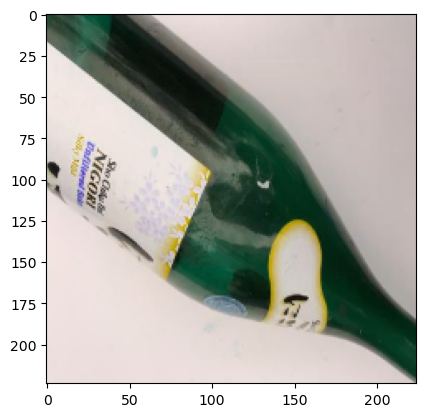

In [57]:
plt.imshow(random.choice(training_data)[0])
plt.show()

## Split into training and testing

In [58]:
train, test = train_test_split(training_data, test_size=0.2, random_state=63)
X_train = []
X_test = []
Y_train = []
Y_test = []
for img, class_id in train:
    X_train.append(img)
    Y_train.append(class_id)
for img, class_id in test:
    X_test.append(img)
    Y_test.append(class_id)
# make X numpy array
X_train = np.array(X_train).reshape(len(X_train), img_size, img_size, 3)
X_test = np.array(X_test).reshape(len(X_test), img_size, img_size, 3)


## Make MobileNet model

In [59]:
model = applications.mobilenet.MobileNet()
base_input = model.layers[0].input
base_output = model.layers[-4].output
flat_layers = layers.Flatten()(base_output)
final_output = layers.Dense(6)(flat_layers)
final_output = layers.Activation('softmax')(final_output)
final_model = Model(inputs=base_input, outputs=final_output)
final_model.compile(loss="binary_crossentropy", optimizer= "adam", metrics=["accuracy"])

## MobileNet Model v2

In [68]:
model = applications.MobileNet(weights='imagenet', include_top = False)

for layer in model.layers:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(model.output)
x = layers.Dense(256, activation='relu')(x)
output = layers.Dense(6, activation='softmax')(x)
# Create the final model
final_model = Model(inputs=model.input, outputs=output)

# Compile the model
final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print a summary of the model architecture
final_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizati  (None, None, None, 32)    128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, None, None, 32)    288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, None, None, 32)    128 

In [71]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
Y_train = np.asarray(Y_train)
Y_test = np.asarray(Y_test)

Y_train = to_categorical(Y_train, num_classes=6)
Y_test = to_categorical(Y_test, num_classes=6)
#print(X_train.shape)
#print(X_test.shape)
#print(Y_train.shape)
#print(Y_test.shape)
history = final_model.fit(X_train, 
                Y_train, 
                epochs=n_epochs, 
                validation_data=(X_test, Y_test),
                batch_size=batch_size)
